In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u282-b08-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
cur_path = "/content/drive/MyDrive/Colab Notebooks/big_data/Final_Project/"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/Colab Notebooks/big_data/Final_Project


Create spark session

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
df = spark.read.csv("netflix_titles.csv", header=True)
df = pd.read_csv("netflix_titles.csv")

In [ ]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


Preprocess the datatype

In [ ]:
df = df.dropna(how='any')

In [ ]:
G = nx.Graph()
added_actor = []
 
def add_movie_and_actors_to_graph(row):
    G.add_node(row.title, type ='movie', color='blue')
    for actor in row.cast.split(", "):
        if actor not in added_actor:
            G.add_node(actor, type = 'actor', color = ('red' if actor=='Kevin Bacon' else 'green'))
            added_actor.append(actor)
        G.add_edge(row.title, actor)

In [ ]:
_ = df.apply(lambda r: add_movie_and_actors_to_graph(r), axis=1)

In [ ]:
import multiprocessing
pool = multiprocessing.Pool(processes = 5)

In [ ]:
actor_list = added_actor.copy()

def compute_distance(a, b, x):
  try: 
    path = nx.shortest_path(G, source=a, target=b)
    dis = int(len(path)/2)
    return dis
  except:
    x+=1

In [ ]:
max_distance = 0
min_distance = 0
no_pairs = 0
results = []
results_list = []

In [ ]:
len(added_actor)

23215

In [ ]:
for j in actor_list:
  if j != 'Kevin Bacon':
    results.append(pool.apply_async(compute_distance, args=['Demián Bichir',j, no_pairs]))

pool.close()
pool.join()
for result in results:
    num = result.get()
    if num:
      results_list.append(num)

In [ ]:
sorted(results_list, reverse=True)[0:10]

[11, 11, 11, 11, 11, 11, 10, 10, 10, 10]

In [ ]:
print('Longest distance:', sorted(results_list, reverse=True)[0])
print('Average distance:', np.array(results_list).mean())
print('Number of actors complying with the Six Degree rule:', len([i for i in results_list if i <= 6]))
print('Number of actors:', len(added_actor))
print('Number of actors not connected:', len(added_actor)-1-len(results_list))


Longest distance: 11
Average distance: 4.128369322412509
Number of actors complying with the Six Degree rule: 19241
Number of actors: 23215
Number of actors not connected: 3069


In [ ]:
random_actors = random.sample(added_actor, 3)

In [ ]:
for a in random_actors:
    path = nx.shortest_path(G,source=a,target='Kevin Bacon')
    print('{0} has a Bacon score of: {1}'.format(a, int(len(path)/2)))
    print(path)

Henry Rollins has a Bacon score of: 4
['Henry Rollins', 'He Never Died', 'Booboo Stewart', 'Grizzlies', 'Will Sasso', 'Movie 43', 'Matt Walsh', 'The Darkness', 'Kevin Bacon']
Josh Hartnett has a Bacon score of: 2
['Josh Hartnett', 'Black Hawk Down', 'Tom Guiry', 'Mystic River', 'Kevin Bacon']
Simone Bailly has a Bacon score of: 3
['Simone Bailly', 'Good Luck Chuck', 'Dan Fogler', 'The Guardian Brothers', 'Meryl Streep', 'The River Wild', 'Kevin Bacon']


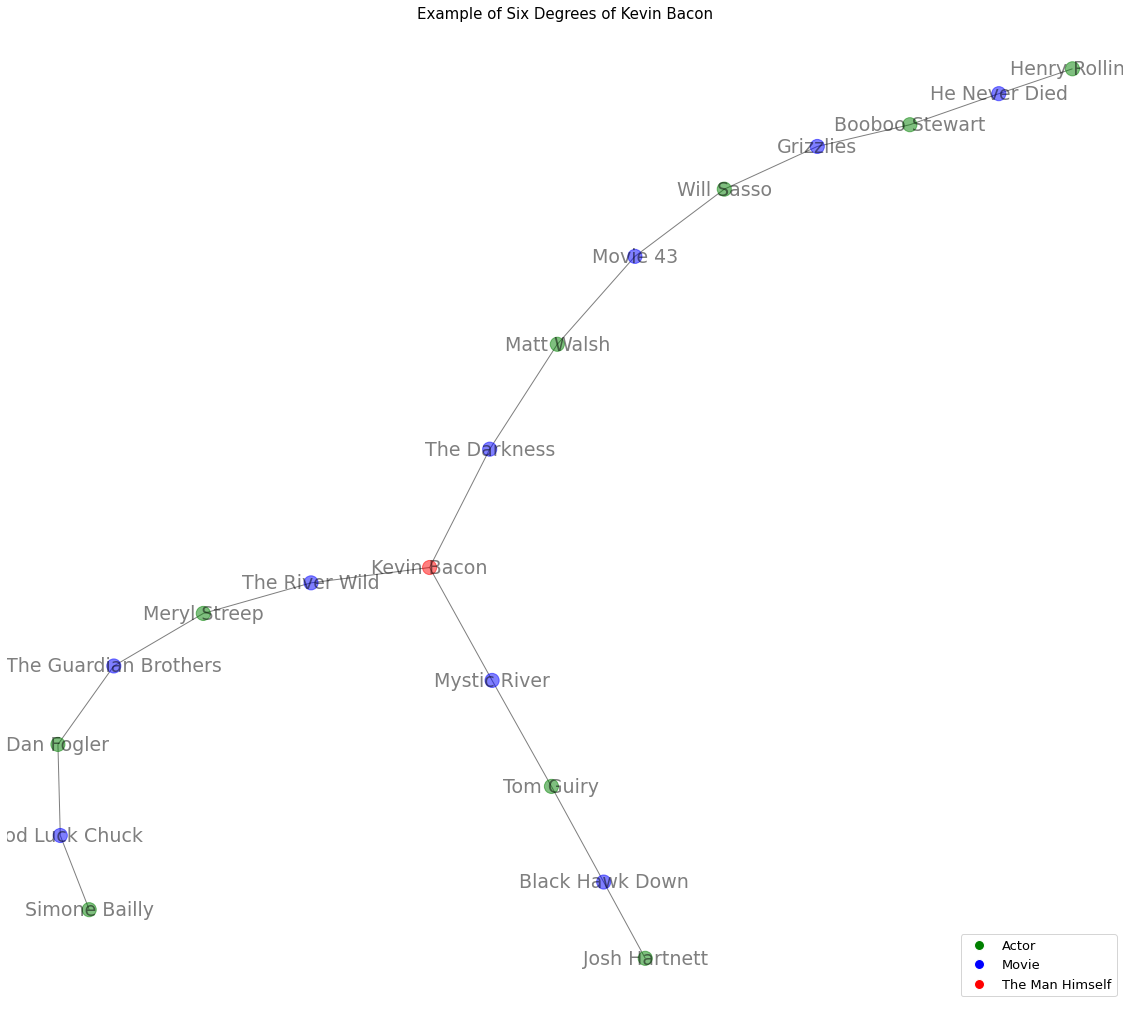

In [ ]:
G_chart = nx.Graph()  # a new graph I spin up just for charting purposes
 
# populate the new graph with the random actors and their paths to Kevin Bacon
for a in random_actors:
    nodes_in_path = nx.shortest_path(G, source=a, target='Kevin Bacon')
    for n in nodes_in_path:
        if not G_chart.has_node(n):
            original_node = [a for a in G.nodes(data=True) if a[0]==n][0]
            # add node and its data payload to the graph i'll use in my chart
            G_chart.add_node(original_node[0], attr_dic = original_node[1])  
    nx.add_path(G_chart, nodes_in_path)
     
fig, ax = plt.subplots(figsize=(20, 18))
 
# networkx layouts can be really tricky: something you just have to play with
pos = nx.spring_layout(G_chart, scale=0.25)
#pos = nx.circular_layout(G_chart)
 
color_map = [n[1]['attr_dic']['color'] for n in G_chart.nodes(data=True)]
labels = {n:n for n in G_chart.nodes()}
 
plt.title('Example of Six Degrees of Kevin Bacon', fontsize=15)
ax.axis('off')
nx.draw_networkx(G_chart, pos, node_color=color_map, alpha=0.5, labels=labels, with_labels=True, ax=ax, node_size=200, font_size=19, font_color='black')
 
from matplotlib.lines import Line2D
custom_legend = [Line2D([0], [0], marker='o', markerfacecolor='g', markersize=10, color='w', label='Actor'), 
                 Line2D([0], [0], marker='o', markerfacecolor='b', markersize=10, color='w', label='Movie'),
                 Line2D([0], [0], marker='o', markerfacecolor='r', markersize=10, color='w', label='The Man Himself')]
ax.legend(handles=custom_legend, loc='lower right', fontsize= 13)